## Dominican Urban Artists Spotify Analysis ##
This is now the third version of this analysis. The goal of this version is to optimize as much as I can to better reflect my growth as a coder. As usual, we'll try and see if we can explain why some artists are more popular than others, by processing their top tracks and measuring how much impact their characteristics such as tempo, rhythm, danceability, etc. do have.

First we'll start importing the libraries we need. We'll use the basic stuff like Pandas, Plotly, Requests, etc, but also a specialized library called **Spotipy** that adapts all the Spotify API endpoints and methods to Python.

In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests as rs
import spotipy as spo
import spotipy.util as util
import numpy as np
from yaml import safe_load
from pandas.io.json import json_normalize
from sklearn.metrics import r2_score
import traceback
%matplotlib inline

Spotify requires authorization in order th process all this. In theory, since I won't be accessing any users' info, I shouldn't need a token, but it seems the Spotipy library needs it. On top of that, while I should request access with no scope (since again, we won't be exploring any user), Spotipy can't handle no scope and returns an error the second time you try to refresh the token. Oh yeah, that's another limitation: Spotify only makes tokens valid for one hour. So yeah, refreshing is gonna be necessary pretty much every time we run this analysis.

In [15]:
with open('creds.yaml', 'r') as file:
    creds = safe_load(file)['spotify_api']


1
client_id = creds["client_id"]
client_secret = creds["client_secret"]
redirect_uri = creds["redirect_uri"]
scope = creds["scope"]

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username") % (sys.argv[0],)
    sys.exit()



In [19]:
sys.argv
username = '12130465298'

In [222]:
#%%
token = util.prompt_for_user_token(username, scope,
client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri
)
token

'BQCo01o81P82acr5j53ZBE7Iqy07ePwhkrQHOJfzkuPbYkBUFcWqnYH-O72dyzxwIocr4l6tqTJcTgjqDSVgM25Ldf3UhG9AlgIRwj_ZSSUaopBgX_pE1h3NgBVLACrpCK1qKirYA1exafMKBxM5DXCLBS67Q2lBNkIpmcOTkYxH1Q'

After we get the token, next step is creating a Spotify object, which will be the basis of all of our requests.

In [224]:
spot = spo.Spotify(auth=token)

We then proceed to create a list of the artists we want to extract and feed it tothe Spotify object with a search method. We'll pick the first result of each search, as 99% of the time, that willbe the artists we're looking for. We're also using the Dominican market, represented by the DO code.

In [93]:
artistas = ["El Alfa", "El Mayor", "Lapiz Conciente", "Amenazzy", "Vakero",
"La Materialista", "Musicologo", "Shadow Blow", "La Insuperable", "Shelow Shaq",
"Secreto", "Químico", "La Manta", "Black Jonas", "Mark B", "Chimbala", "Kikada",
"Poeta Callejero", "Rochy RD", "Kiko El Crazy", "Don Miguelo", "Sensato",
"Mozart La Para", "Lirico En La Casa", "Liro Shaq", "Super Nuevo",
"Amara La Negra", "Bulova", "Crazy Design", "MelyMel", "Chuape", "Bulin 47",
"Milka La Mas Dura", "Ceky Vicini", "Carlitos Way", "Manyao", "El Cherry Scom",
"Tokischa", "Haraca Kiko", "Yomel El Meloso", "Pablo Piddy", "Doble T y El Crok"
]
artists_id = {}
for art in artistas:
    try:
        temp = spot.search(q=f"artist: {art}", type = "artist", market="DO")
        artists_id[art] = temp["artists"]["items"][0]
    except:
        print(f'{art} no fue encontrado')

Here we check one of the artists' dictionary to identify the columns we want. In this case we'll choose **Name, Popularity and ID** since those seem to be the most relevant for our needs. Genres might be useful, but it's either not standardized across artists or will just complicate matters unneedlessly.

In [32]:
artists_id["El Alfa"]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2oQX8QiMXOyuqbcZEFsZfm'},
 'followers': {'href': None, 'total': 1856527},
 'genres': ['dembow', 'latin', 'rap dominicano', 'reggaeton', 'trap latino'],
 'href': 'https://api.spotify.com/v1/artists/2oQX8QiMXOyuqbcZEFsZfm',
 'id': '2oQX8QiMXOyuqbcZEFsZfm',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eba97f2c907b36d3c1d8e58397',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174a97f2c907b36d3c1d8e58397',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178a97f2c907b36d3c1d8e58397',
   'width': 160}],
 'name': 'El Alfa',
 'popularity': 80,
 'type': 'artist',
 'uri': 'spotify:artist:2oQX8QiMXOyuqbcZEFsZfm'}

We then proceed to extract the keys we chose and put them in a list, then use that info to create a DataFrame. Pretty basic stuff.

In [33]:
artists_info = []
for key in artists_id:
    relevant = dict((k, artists_id[key][k]) for k in ['name', 'popularity', "id"] if k in artists_id[key])
    artists_info.append(list(relevant.values()))
artists_info

[['El Alfa', 80, '2oQX8QiMXOyuqbcZEFsZfm'],
 ['El Mayor Clasico', 48, '5sZ0LIk7BJLJquEUUt5rJj'],
 ['Lapiz Conciente', 55, '0UTsdD7VIsEB9i7a6DDx5t'],
 ['Amenazzy', 71, '6kq4GHwUcUojGIu0ziSNXf'],
 ['Vakero', 44, '5rlwbF5flU2JCmAzV5Obu0'],
 ['La Materialista', 35, '4FMqE1IWlhufYw1x2zlKG6'],
 ['Musicologo The Libro', 50, '0lIw3RIPiAC50dWNjJXe2Q'],
 ['Shadow Blow', 53, '53cVnpkm8dTmf20tssYSNF'],
 ['La Insuperable', 44, '1DnmGMN1A57wUR0KhxOnnu'],
 ['Shelow Shaq', 54, '658X86qMyJpSRY87oPvExU'],
 ['Secreto "El Famoso Biberon"', 58, '37UACiDcdzEYii0iU0QpAf'],
 ['Quimico Ultra Mega', 62, '3tZdknQnzsVIIdaGCTj4RX'],
 ['La Manta Rd', 34, '4zEkMRxNAtvWhnaUr3ukOJ'],
 ['Black Jonas Point', 49, '5ImkeVBlU11axX5QwOWg12'],
 ['Mark B.', 53, '0zZJhc1T0zBurhnBwQ2fcu'],
 ['Chimbala', 74, '4VVEpEhC8NcR7AqNEds42U'],
 ['La Kikada', 43, '7Fpb4yEAPfiQfY0Bx0uLm5'],
 ['Poeta Callejero', 42, '1m82A2YUjBaQnLAFi9vjJv'],
 ['Rochy RD', 71, '4riOEaOW5hCeqomFDBk0aP'],
 ['Kiko el Crazy', 60, '3NpG6SsHaQETkdQVZH6V1E'],
 ['D

In [34]:
urbanos = pd.DataFrame(artists_info, columns=["name", "popularity", "artist_id"])

In [86]:
for item in list(urbanos.iterrows())[:5]:
    print(item[1]['name'])


El Alfa
El Mayor Clasico
Lapiz Conciente
Amenazzy
Vakero


In [216]:
urbanos.sort_values('popularity', ascending=False)
urbanos.columns = ['artist_name', 'artist_popularity', 'artist_id']
urbanos

,artist_name,artist_popularity,artist_id
0,El Alfa,80,2oQX8QiMXOyuqbcZEFsZfm
1,El Mayor Clasico,48,5sZ0LIk7BJLJquEUUt5rJj
2,Lapiz Conciente,55,0UTsdD7VIsEB9i7a6DDx5t
3,Amenazzy,71,6kq4GHwUcUojGIu0ziSNXf
4,Vakero,44,5rlwbF5flU2JCmAzV5Obu0
5,La Materialista,35,4FMqE1IWlhufYw1x2zlKG6
6,Musicologo The Libro,50,0lIw3RIPiAC50dWNjJXe2Q
7,Shadow Blow,53,53cVnpkm8dTmf20tssYSNF
8,La Insuperable,44,1DnmGMN1A57wUR0KhxOnnu
9,Shelow Shaq,54,658X86qMyJpSRY87oPvExU


Instead of looking for the top tracks, which only returns 10 tracks per artists, we're going to get massive and pull several albums from each artist and then get all of those songs' features.

In [231]:
album_ids = {}
cantidad_tracks = {}

for item in list(urbanos.iterrows()):
    art_name = item[1]['artist_name']
    art_id = item[1]['artist_id']
    
    try:
        temp = spot.artist_albums(art_id)
        cantidad_tracks[art_name] = sum([album['total_tracks'] for album in temp['items']])
        album_ids[art_name] = [album['id'] for album in temp['items']]
    except Exception:
        traceback.print_exc()
    print(f'termino con {art_name}')
    print(f'{art_name} tiene {cantidad_tracks[art_name]} canciones')



termino con El Alfa
El Alfa tiene 130 canciones
termino con El Mayor Clasico
El Mayor Clasico tiene 21 canciones
termino con Lapiz Conciente
Lapiz Conciente tiene 158 canciones
termino con Amenazzy
Amenazzy tiene 27 canciones
termino con Vakero
Vakero tiene 98 canciones
termino con La Materialista
La Materialista tiene 56 canciones
termino con Musicologo The Libro
Musicologo The Libro tiene 51 canciones
termino con Shadow Blow
Shadow Blow tiene 61 canciones
termino con La Insuperable
La Insuperable tiene 26 canciones
termino con Shelow Shaq
Shelow Shaq tiene 163 canciones
termino con Secreto "El Famoso Biberon"
Secreto "El Famoso Biberon" tiene 53 canciones
termino con Quimico Ultra Mega
Quimico Ultra Mega tiene 97 canciones
termino con La Manta Rd
La Manta Rd tiene 2 canciones
termino con Black Jonas Point
Black Jonas Point tiene 133 canciones
termino con Mark B.
Mark B. tiene 20 canciones
termino con Chimbala
Chimbala tiene 20 canciones
termino con La Kikada
La Kikada tiene 20 cancio

In [232]:
album_ids

{'El Alfa': ['4v25w5u9JmarAGjE3jcByx',
  '4XVaLKYULaqkqBxYrPz7n6',
  '2go4TPY4tcBF0GIlHGg1x9',
  '5hzbgBTxfikktf9cOvggGF',
  '4Qwz7NX3o56AlOR99WRwgw',
  '5zU2SQAOUTmQvRm6O1Gs3X',
  '7yS1RMcw03GA0N4jbl2bgU',
  '3VRRzMuuqpMX5UsObjwTPp',
  '5VxtXZZq5kOm3JhDQddaDA',
  '6uzezSBR2loiWEjeRFu8VM',
  '1DJ8Ix9b7yJhtrqus02M3w',
  '2V3oEJWhKr8oYA9VwvPCPX',
  '1ubYagKmXunmu8XSa3jVt2',
  '4GGkJWt68bz62NUEoNnLUD',
  '5AVKorAwqFCfUiPkNwv89o',
  '2cmERLzPC9l87fy9sTzedd',
  '3h3vLHJVJZMDrSfshwsSmz',
  '2yzn76Jz0OhnP5VqwRb426',
  '2HTiDtOTtg9Ri1qPeoB0ud',
  '2WG76KEpCWL8c790ZIEXk7'],
 'El Mayor Clasico': ['1ZEtT1atHrqyV6OkdS8vtK',
  '15x239VxOAAui3YJtaIBUB',
  '7iWvqLkHlI0llx4VcYraWM',
  '3DmXU71GfSlW4I3ybWDCN3',
  '1f0XIPQ20NUVf1680FcxfG',
  '4UMQs0WnOWdpXN0L8fNlV8',
  '37pA8p3PeZ7WtCFPhwM7gS',
  '1jWb3wSH3k7PV6sVvVziFi',
  '0KpmaGVRJW483iGeXY4q2T',
  '0TH9Cyr4EJ0KXtLcE7vYDu',
  '5VMp05LHlsnBddDQ9ncx2C',
  '4wbCtVIdvFHRDjYVL34XMM',
  '3lOtFDx1YT75eZQB21l3ki',
  '4KWLcPShRwJtb0vxcSfYVW',
  '2Z5rbEf2B5G02

In [233]:
album_ids = pd.DataFrame.from_dict(album_ids, orient='index').transpose().melt().dropna()
album_ids.columns = ['artist_name', 'album_id']
album_ids

,artist_name,album_id
0,El Alfa,4v25w5u9JmarAGjE3jcByx
1,El Alfa,4XVaLKYULaqkqBxYrPz7n6
2,El Alfa,2go4TPY4tcBF0GIlHGg1x9
3,El Alfa,5hzbgBTxfikktf9cOvggGF
4,El Alfa,4Qwz7NX3o56AlOR99WRwgw
...,...,...
819,Pablo Piddy,3r2jWcL8ZY7GIQeJOd6lXS
820,Doble T & El Crok,4v25w5u9JmarAGjE3jcByx
821,Doble T & El Crok,4XVaLKYULaqkqBxYrPz7n6
822,Doble T & El Crok,1gKw6JjsG3cBe6lmE07IhP


In [195]:
for row in album_ids.iterrows():
    temp_art, temp_id = row[1].values
    print(temp_art, temp_id)


El Alfa 4v25w5u9JmarAGjE3jcByx
El Alfa 4XVaLKYULaqkqBxYrPz7n6
El Alfa 2go4TPY4tcBF0GIlHGg1x9
El Alfa 5hzbgBTxfikktf9cOvggGF
El Alfa 4Qwz7NX3o56AlOR99WRwgw
El Alfa 5zU2SQAOUTmQvRm6O1Gs3X
El Alfa 7yS1RMcw03GA0N4jbl2bgU
El Alfa 3VRRzMuuqpMX5UsObjwTPp
El Alfa 5VxtXZZq5kOm3JhDQddaDA
El Alfa 6uzezSBR2loiWEjeRFu8VM
El Alfa 1DJ8Ix9b7yJhtrqus02M3w
El Alfa 2V3oEJWhKr8oYA9VwvPCPX
El Alfa 1ubYagKmXunmu8XSa3jVt2
El Alfa 4GGkJWt68bz62NUEoNnLUD
El Alfa 5AVKorAwqFCfUiPkNwv89o
El Alfa 2cmERLzPC9l87fy9sTzedd
El Alfa 3h3vLHJVJZMDrSfshwsSmz
El Alfa 2yzn76Jz0OhnP5VqwRb426
El Alfa 2HTiDtOTtg9Ri1qPeoB0ud
El Alfa 2WG76KEpCWL8c790ZIEXk7
El Mayor Clasico 1ZEtT1atHrqyV6OkdS8vtK
El Mayor Clasico 15x239VxOAAui3YJtaIBUB
El Mayor Clasico 7iWvqLkHlI0llx4VcYraWM
El Mayor Clasico 3DmXU71GfSlW4I3ybWDCN3
El Mayor Clasico 1f0XIPQ20NUVf1680FcxfG
El Mayor Clasico 4UMQs0WnOWdpXN0L8fNlV8
El Mayor Clasico 37pA8p3PeZ7WtCFPhwM7gS
El Mayor Clasico 1jWb3wSH3k7PV6sVvVziFi
El Mayor Clasico 0KpmaGVRJW483iGeXY4q2T
El Mayor Clasico 0TH

In [240]:
def get_track_info(track):
    temp = spot.track(track)
    cols = ["name", "popularity", "duration_ms", "id"]
    temp = pd.DataFrame(index=cols, data=[temp[c] for c in cols]).transpose()
    temp.columns = [f'track_{c}' for c in temp.columns]
    return temp
    # temp = pd.DataFrame.from_dict(temp, orient='index').transpose().melt().dropna()
    # return temp[["name", "popularity", "duration_ms", "id"]]

album_dfs = []
for row in album_ids.iterrows():
    temp_artist, temp_album_id = row[1].values
    temp_tracks = spot.album_tracks(temp_album_id)['items']
    temp_tracks = pd.DataFrame(temp_tracks)
    temp_tracks = pd.concat(temp_tracks.id.apply(get_track_info).values)
    temp_tracks['album_id'] = temp_album_id
    temp_tracks['artist_name'] = temp_artist
    album_dfs.append(temp_tracks)






In [243]:
albums_df = pd.concat(album_dfs).reset_index(drop=True)
albums_df.to_csv('spotify_tracks.csv')

In [245]:
data = pd.merge(urbanos, albums_df, on='artist_name')
data.to_csv('spotify_tracks.csv')

Then from those songs we extract Song Popularity, Duration and match it with each artist's info.

In [4]:
data = pd.read_csv('spotify_tracks.csv', index_col=0)

In [5]:
data.head()

,artist_name,artist_popularity,artist_id,track_name,track_popularity,track_duration_ms,track_id,album_id,danceability,energy,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,El Alfa,80,2oQX8QiMXOyuqbcZEFsZfm,Recogelo,50,171282,1VDSBoi7eGLGxh10nVHUfN,4v25w5u9JmarAGjE3jcByx,0.603,0.758,...,0.0833,0.571,155.770,audio_features,1VDSBoi7eGLGxh10nVHUfN,spotify:track:1VDSBoi7eGLGxh10nVHUfN,https://api.spotify.com/v1/tracks/1VDSBoi7eGLG...,https://api.spotify.com/v1/audio-analysis/1VDS...,171282,5
1,El Alfa,80,2oQX8QiMXOyuqbcZEFsZfm,Recogelo,50,171282,1VDSBoi7eGLGxh10nVHUfN,4v25w5u9JmarAGjE3jcByx,0.603,0.758,...,0.0833,0.571,155.770,audio_features,1VDSBoi7eGLGxh10nVHUfN,spotify:track:1VDSBoi7eGLGxh10nVHUfN,https://api.spotify.com/v1/tracks/1VDSBoi7eGLG...,https://api.spotify.com/v1/audio-analysis/1VDS...,171282,5
2,Doble T & El Crok,33,3Anf3i96TXH6hfimL1F6MY,Recogelo,50,171282,1VDSBoi7eGLGxh10nVHUfN,4v25w5u9JmarAGjE3jcByx,0.603,0.758,...,0.0833,0.571,155.770,audio_features,1VDSBoi7eGLGxh10nVHUfN,spotify:track:1VDSBoi7eGLGxh10nVHUfN,https://api.spotify.com/v1/tracks/1VDSBoi7eGLG...,https://api.spotify.com/v1/audio-analysis/1VDS...,171282,5
3,Doble T & El Crok,33,3Anf3i96TXH6hfimL1F6MY,Recogelo,50,171282,1VDSBoi7eGLGxh10nVHUfN,4v25w5u9JmarAGjE3jcByx,0.603,0.758,...,0.0833,0.571,155.770,audio_features,1VDSBoi7eGLGxh10nVHUfN,spotify:track:1VDSBoi7eGLGxh10nVHUfN,https://api.spotify.com/v1/tracks/1VDSBoi7eGLG...,https://api.spotify.com/v1/audio-analysis/1VDS...,171282,5
4,El Alfa,80,2oQX8QiMXOyuqbcZEFsZfm,Un Dia Si,50,164307,5qRhzFjGqvJN9RSQRFV2J2,4v25w5u9JmarAGjE3jcByx,0.859,0.663,...,0.2510,0.622,154.978,audio_features,5qRhzFjGqvJN9RSQRFV2J2,spotify:track:5qRhzFjGqvJN9RSQRFV2J2,https://api.spotify.com/v1/tracks/5qRhzFjGqvJN...,https://api.spotify.com/v1/audio-analysis/5qRh...,164308,4


Now we're going to get advantage of Spotify's ready made analysis results in the form of song features. These will provide us really meaty information for our upcoming analysis.

In [247]:
song_features = [spot.audio_features(song) for song in data["track_id"]]


In [263]:
song_features = pd.DataFrame(columns=song_features[0][0].keys(), data=[l[0].values() for l in song_features])
song_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.603,0.758,0,-4.980,0,0.3930,0.2970,0.009240,0.0833,0.5710,155.770,audio_features,1VDSBoi7eGLGxh10nVHUfN,spotify:track:1VDSBoi7eGLGxh10nVHUfN,https://api.spotify.com/v1/tracks/1VDSBoi7eGLG...,https://api.spotify.com/v1/audio-analysis/1VDS...,171282,5
1,0.859,0.663,1,-4.247,0,0.1820,0.0932,0.000003,0.2510,0.6220,154.978,audio_features,5qRhzFjGqvJN9RSQRFV2J2,spotify:track:5qRhzFjGqvJN9RSQRFV2J2,https://api.spotify.com/v1/tracks/5qRhzFjGqvJN...,https://api.spotify.com/v1/audio-analysis/5qRh...,164308,4
2,0.853,0.909,7,-2.473,1,0.2290,0.0522,0.022300,0.1290,0.8030,112.987,audio_features,4QfZYDhGZc0T2RDvGiI69E,spotify:track:4QfZYDhGZc0T2RDvGiI69E,https://api.spotify.com/v1/tracks/4QfZYDhGZc0T...,https://api.spotify.com/v1/audio-analysis/4QfZ...,178407,4
3,0.790,0.453,2,-8.238,1,0.1210,0.1390,0.000000,0.1080,0.0997,119.018,audio_features,05tNrQNICAOfX8ohVpfkBb,spotify:track:05tNrQNICAOfX8ohVpfkBb,https://api.spotify.com/v1/tracks/05tNrQNICAOf...,https://api.spotify.com/v1/audio-analysis/05tN...,229916,4
4,0.826,0.499,1,-8.700,1,0.1880,0.1710,0.010600,0.3120,0.3500,80.977,audio_features,1i14jDizhAPxpfZRxAOtnc,spotify:track:1i14jDizhAPxpfZRxAOtnc,https://api.spotify.com/v1/tracks/1i14jDizhAPx...,https://api.spotify.com/v1/audio-analysis/1i14...,176254,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,0.479,0.891,9,-2.381,1,0.3580,0.2150,0.000000,0.0599,0.6620,196.725,audio_features,3l7pez1RCiaApkeNOxJeri,spotify:track:3l7pez1RCiaApkeNOxJeri,https://api.spotify.com/v1/tracks/3l7pez1RCiaA...,https://api.spotify.com/v1/audio-analysis/3l7p...,193724,4
2378,0.887,0.943,11,-3.121,0,0.0604,0.0761,0.000183,0.2370,0.8850,115.045,audio_features,6nNAhy72TK8NqwcpFEA7Su,spotify:track:6nNAhy72TK8NqwcpFEA7Su,https://api.spotify.com/v1/tracks/6nNAhy72TK8N...,https://api.spotify.com/v1/audio-analysis/6nNA...,158511,4
2379,0.746,0.898,1,-1.919,1,0.1880,0.0531,0.863000,0.2870,0.8990,124.723,audio_features,6uVVWMwMXF9YxMMv6EAfd5,spotify:track:6uVVWMwMXF9YxMMv6EAfd5,https://api.spotify.com/v1/tracks/6uVVWMwMXF9Y...,https://api.spotify.com/v1/audio-analysis/6uVV...,131056,4
2380,0.578,0.769,2,-8.787,1,0.6290,0.1930,0.000000,0.2660,0.8710,92.954,audio_features,2Z8ZMyFboU9hZRltmOab0G,spotify:track:2Z8ZMyFboU9hZRltmOab0G,https://api.spotify.com/v1/tracks/2Z8ZMyFboU9h...,https://api.spotify.com/v1/audio-analysis/2Z8Z...,226586,4


In [274]:
print(data.shape)
print(song_features.shape)
data = pd.merge(data, song_features, left_on='track_id', right_on='id', how='inner')
print(data.shape)

(2382, 8)
(2382, 18)
(2574, 26)


After combining the artist info with the song features, we'll save out dataframe for future use.

In [279]:
data.to_csv('spotify_tracks.csv')

In [9]:
tracks = pd.read_csv('spotify_tracks.csv', index_col=0)

In [23]:
tracks.artist_name.shape

(2574,)

We now save tracks and track features into CSVs so we don't have to call the API anymore.

After concatenating the previous dataframes and selecting the appropriate columns, we now have a nice list of 2,574 songs from 42 artists, and each song features.

In [24]:
# Here we'll create a colormap based on the artists for categorical colorization
tags = {}
for a in range(len(tracks.artist_name.unique())):
    tags[tracks["artist_name"].unique()[a]] = a
artist_map = [tags[a] for a in tracks["artist_name"]]

In [26]:
tracks.columns

Index(['artist_name', 'artist_popularity', 'artist_id', 'track_name',
       'track_popularity', 'track_duration_ms', 'track_id', 'album_id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [33]:
px.histogram(
    tracks,
    x='track_popularity',
    template='plotly_dark'
)

In [29]:
tracks.track_popularity.max(), tracks.track_popularity.min()

(86, 0)

In [30]:
tracks.track_popularity.describe()

count    2574.000000
mean       14.207459
std        15.426911
min         0.000000
25%         1.000000
50%         8.000000
75%        23.000000
max        86.000000
Name: track_popularity, dtype: float64

Popularity range goes from 0 to 86, on a 100 scale. 75% are below 23%.

Let's see a scatter to look see the relation between artist popularity and track popularity.

In [34]:
fig = px.scatter(
    tracks, x='artist_popularity', y='track_popularity',
    color='artist_name',
    hover_data=['track_name']
    # width=1200, height=600
)
# fig.update_layout(hovermode="x unified")
fig

As expected, there's a direct correlation between an artist popularity and the popularity of the songs they produce. Although said effect diminishes a bit as artist popularity grows. Seems there's only so much it can help the material beyond he song's performance. If we look closer, we'll notice two facts:

- It's uncommon that a song gets to be more popular than the artist that produced it.
- Artists have a range of around 15-30 points spread for the popularity of their songs, it's extremely rare that a song gets outside that range for any artist.
- Artists like **Carlito's Way** and **Doble T y el Crok** really benefit from featuring songs as they have a few that overperform thanks to playing cameo/parts in songs from artists more successfull than them.

We'll build a feature comparison tool, which will use **r2_score** to find which features offer the highest determination coefficient.

In [100]:
def compare_features(df, col, title=None):
    if title==None:
        title = f"Song Popularity vs {col.title()}"
    x = df[col]
    y = df['track_popularity']
    z = np.polyfit(x, y, 1)
    y_hat = np.poly1d(z)(x)
    df.plot(kind="scatter", x=col, y='track_popularity', c='track_popularity', s=50,
                     colormap=plt.cm.get_cmap('coolwarm',8),
                     title=title, figsize = (12,8), legend=True)
    # z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"k--")
    text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
    plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top')
    plt.show()
    

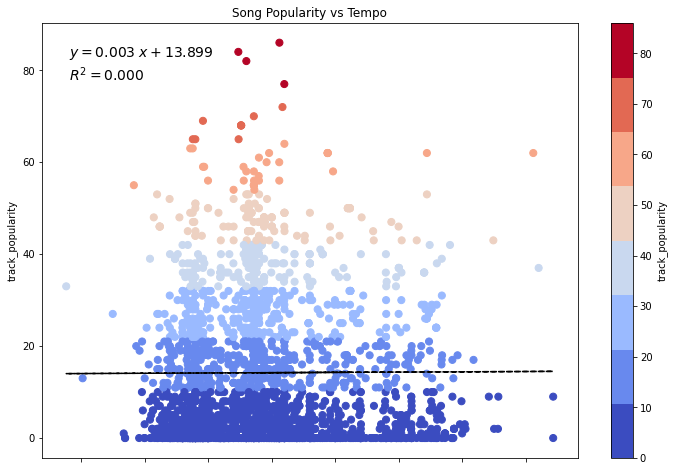

In [101]:
compare_features(tracks, 'tempo')

Tempo seems to have little impact on popularity.

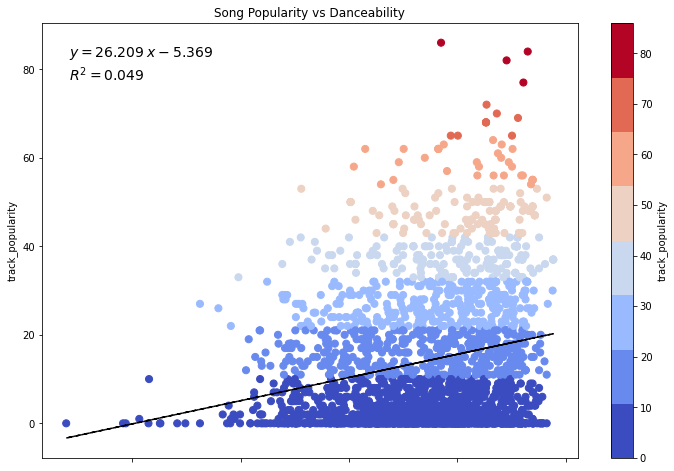

In [102]:
compare_features(tracks, "danceability")

So-called danceability has a noticeable effect on the popularity of songs, which makes sense since it's a danceable rhythm.

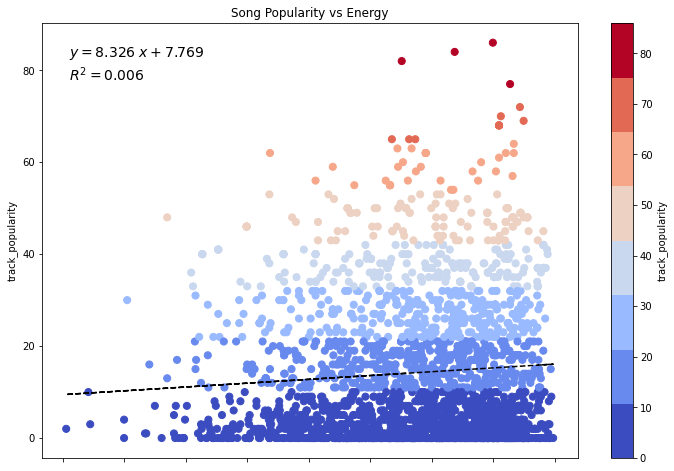

In [103]:
compare_features(tracks, 'energy')

The so-called energy, seems to have little effect on popularity.

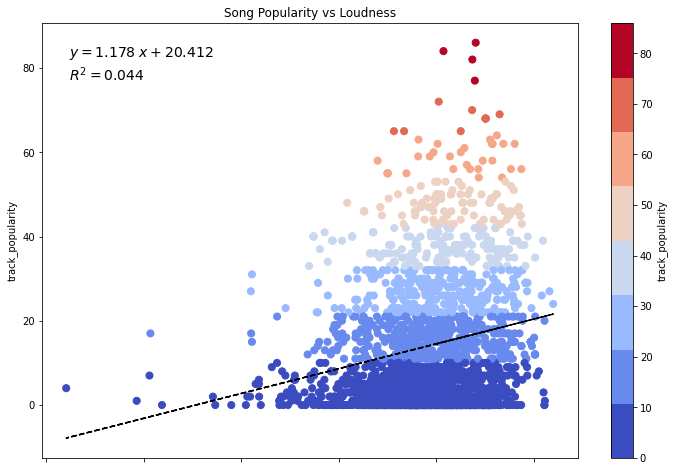

In [104]:
compare_features(tracks, 'loudness')

Loudness seems to have a big impact on popularity, which also makes sense since dembow is usually enjoyed at very loud volumes in parties, houseparties and tailgate parties.

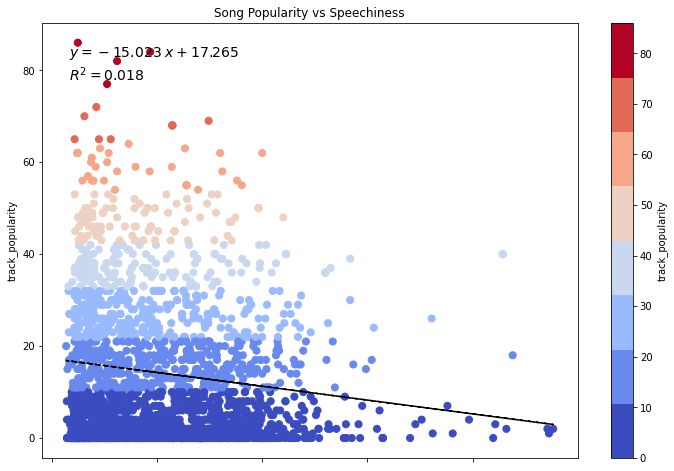

In [105]:
compare_features(tracks, 'speechiness')

This one is pretty funny, because dembow it's known for having little lyrics and focusing on repetitive phrases sychronized to the slapping music. So the fact there's *indeed* a negative correlation between amount of speech and popularity is quite hilarious.

Let's find the ratio of speech to instrumentalness, to derive the overall most talkative songs and then see how that new feature stacks up.

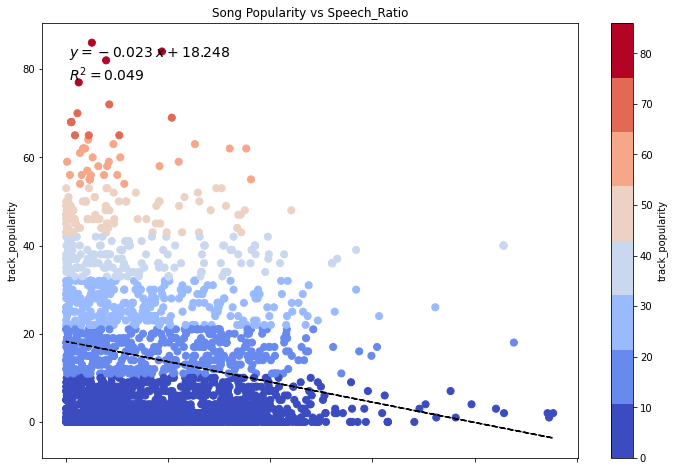

In [106]:
tracks["speech_ratio"] = (tracks["speechiness"]+0.001) / (tracks["instrumentalness"]+0.001)
compare_features(tracks, 'speech_ratio')

Oh, now this is surprising, although not unexpected. There's a very high correlation between how instrumental a song is, and how popular it is. Which relates to the previous graphic and drives the point home even harder: If you want your dembow to be successful, sing the least as possible, as dembow **is not** a heavy lyric genre.

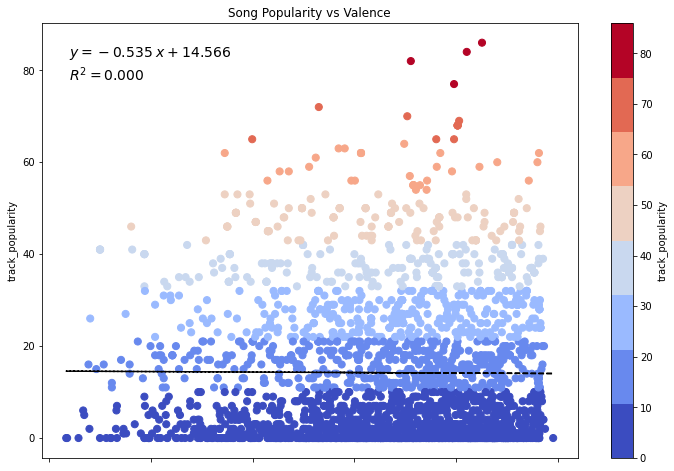

In [107]:
compare_features(tracks, 'valence')

As with danceability, there seems to be an issue with valence. Doesn't seem to be a feature that is predictive of dembow as most dembow is already upsirited.

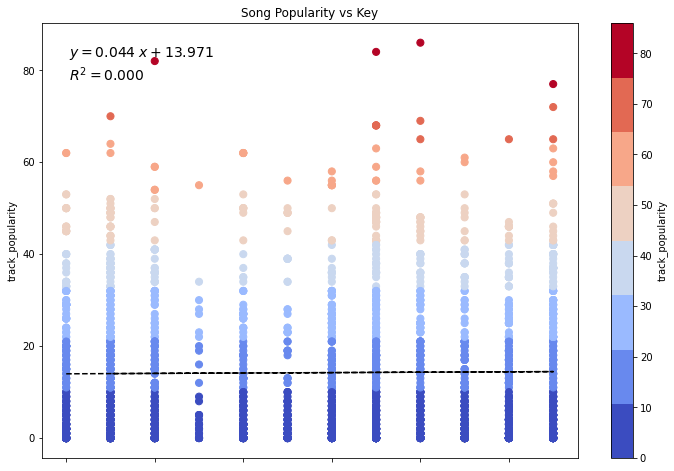

In [108]:
compare_features(tracks, 'key')

Key doesn't seem to really affect song popularity.

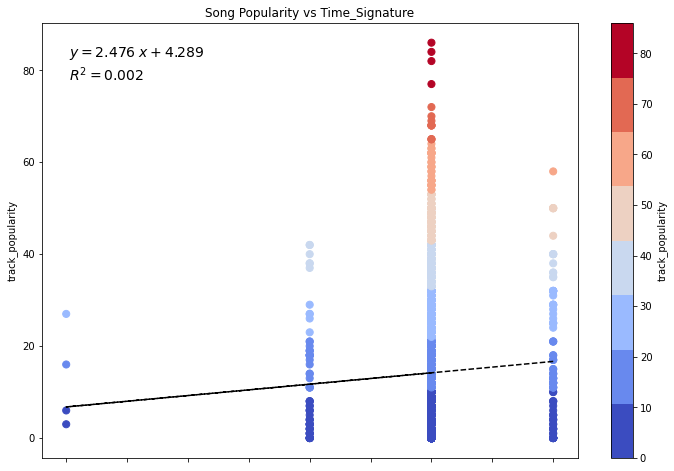

In [109]:
compare_features(tracks, 'time_signature')

Time signature does have a considerable influence on the popularity of a song, with higher signatures representing a faster-paced tempo, which we already know plays a big part on a song's success.

Now let's see how each features stack up when we look at them by artist. We'll get the mean of each feature per artist.

In [114]:
mean_urbanos = tracks.groupby("artist_name").agg(np.mean)

In [115]:
mean_urbanos

,artist_popularity,track_popularity,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,speech_ratio
artist_name,,,,,,,,,,,,,,,,,
Amara La Negra,33.0,8.882353,192103.676471,0.701706,0.729088,5.529412,-5.423529,0.352941,0.239218,0.213104,0.010931,0.167897,0.663559,124.999500,192104.088235,3.911765,219.620934
Amenazzy,71.0,38.555556,189815.259259,0.763889,0.646222,4.851852,-6.088333,0.592593,0.186874,0.275811,0.011250,0.133681,0.586519,127.549222,189815.481481,4.037037,174.531811
Black Jonas Point,49.0,5.485294,208549.705882,0.698787,0.776654,5.860294,-5.450794,0.470588,0.235368,0.210629,0.001946,0.317262,0.622699,121.598684,208550.205882,4.014706,218.755830
Bulin 47,56.0,29.470588,194628.088235,0.854235,0.802294,5.588235,-3.671324,0.794118,0.172721,0.146592,0.007427,0.279426,0.764353,115.772853,194628.529412,4.000000,129.652538
Bulova,55.0,15.000000,213452.470588,0.741971,0.767941,5.455882,-5.101603,0.544118,0.241668,0.242676,0.005851,0.204956,0.725456,115.348647,213453.000000,4.044118,205.584177
Carlitos Way,23.0,8.567961,217086.791262,0.708598,0.749092,5.757282,-6.298316,0.543689,0.191583,0.179013,0.012876,0.238706,0.601824,113.371650,217087.189320,3.980583,178.875720
Ceky Vicini,3.0,4.333333,206817.333333,0.820667,0.853333,5.333333,-3.129000,0.333333,0.238333,0.186300,0.000004,0.280867,0.584667,119.284333,206817.333333,4.000000,238.402700
Chimbala,74.0,39.375000,206706.916667,0.835875,0.807250,6.583333,-2.933250,0.791667,0.131408,0.168750,0.039737,0.153500,0.829917,138.460625,206707.541667,4.000000,50.130230
Crazy Design,42.0,9.400000,179424.371429,0.734143,0.747086,4.600000,-5.285657,0.600000,0.280060,0.421120,0.016927,0.196140,0.640486,134.382429,179424.914286,3.914286,246.367113


<AxesSubplot:ylabel='artist_name'>

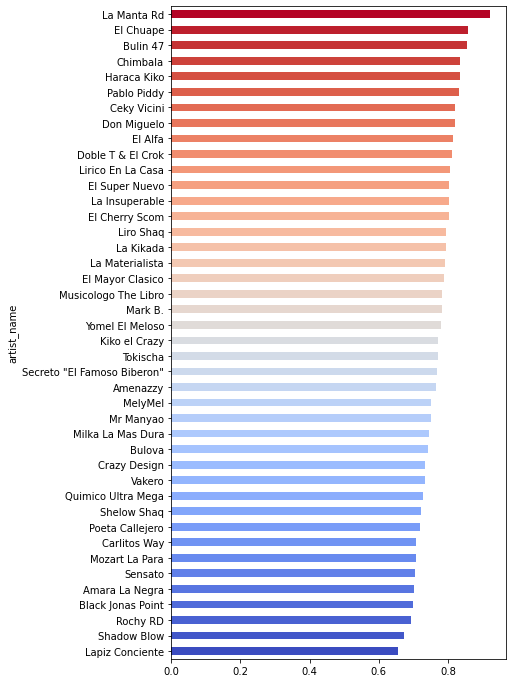

In [118]:
cmap = plt.cm.coolwarm(np.linspace(0,1,len(mean_urbanos)))
mean_urbanos["danceability"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)



Even though when looking at popularity by song we found that *danceability* has little effect and doubted the Spotify algorythms, when we look by artist, we do kind of see that it kinda matches with reality as Haraca Kiko, Ceky, Bulin, Chuape and others feature very catchy songs that make you bob unintentionally. But also artists like El Alfa and Don Miguelo, who are very popular, are among the most danceable ones.

In [117]:
tempo = tracks.sort_values(by="tempo", ascending=False).head(10).reset_index(drop=True)
tempo.index = tempo.index+1

<AxesSubplot:ylabel='artist_name'>

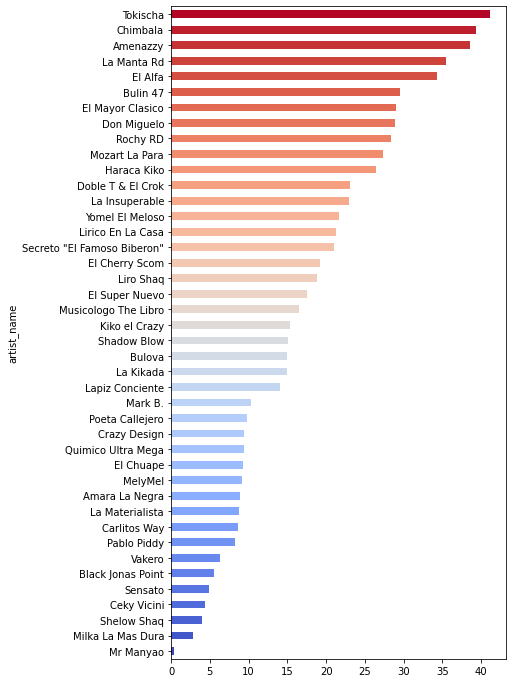

In [120]:
cmap = plt.cm.coolwarm(np.linspace(0,1,len(mean_urbanos)))
mean_urbanos["track_popularity"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)

The high majority of featured dominican urban artists fall on an average song popularity between 10-30, then we have the clear outliers on the bottom side, such as **Ceky, Milka, Manyao and Shelow Shaq**, and the outliers on the top side, such as **Tokischa, Chimbala, Amenazzy, and Alfa**.

<AxesSubplot:ylabel='artist_name'>

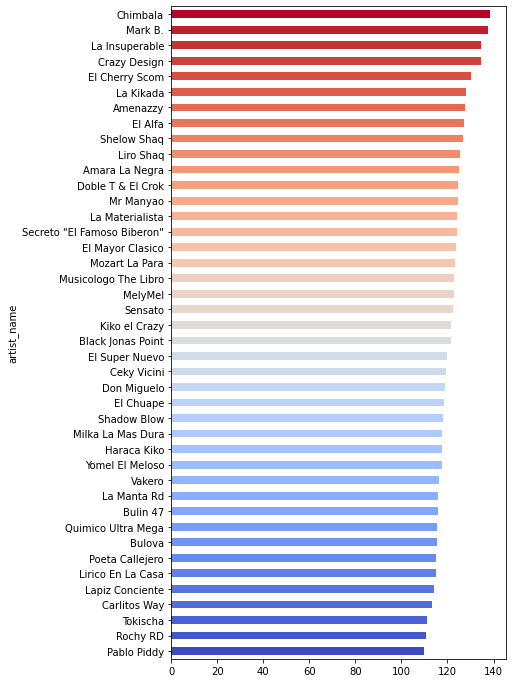

In [121]:
cmap = plt.cm.coolwarm(np.linspace(0,1,len(mean_urbanos)))
mean_urbanos["tempo"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)


If we look at artists by the *energy* parameter, there's overall little difference as they all range between 115-140 BPM, with **Chimbala, Mark B, Insuperable and Crazy Design** having a higher tempo than the rest.

<AxesSubplot:ylabel='artist_name'>

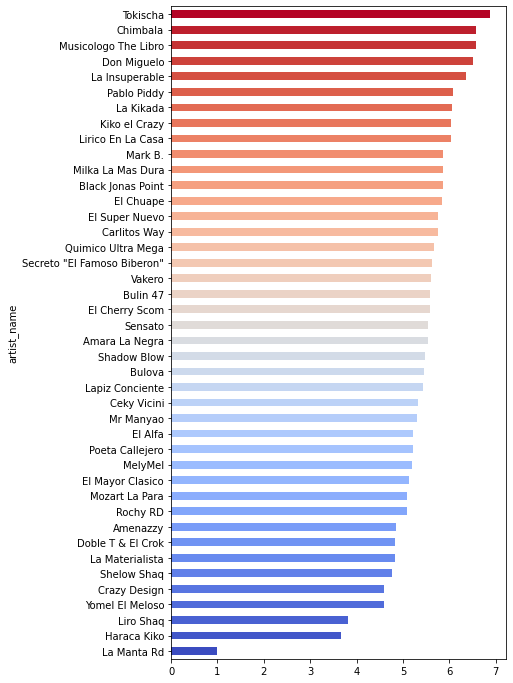

In [122]:
cmap = plt.cm.coolwarm(np.linspace(0,1,len(mean_urbanos)))
mean_urbanos["key"].sort_values().plot(kind="barh", figsize=(6,12), color=cmap)

It's interesting that most of Tokischa's song are on 7 Key, given her astounding rise to popularity. Certainly seems to be an element of her success so far.

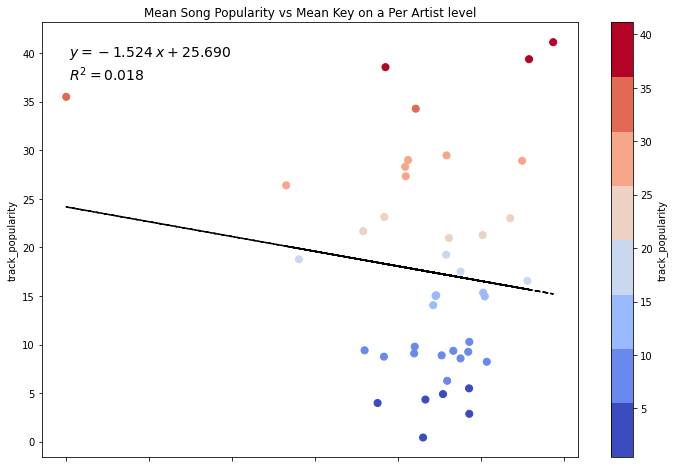

In [123]:
compare_features(mean_urbanos, 'key', title="Mean Song Popularity vs Mean Key on a Per Artist level")


While artists such as El Alfa and Chimbala are among the ones with the most popular songs, yet their key height is average or below average, there's an apparent link between having popular songs and using a higher key.

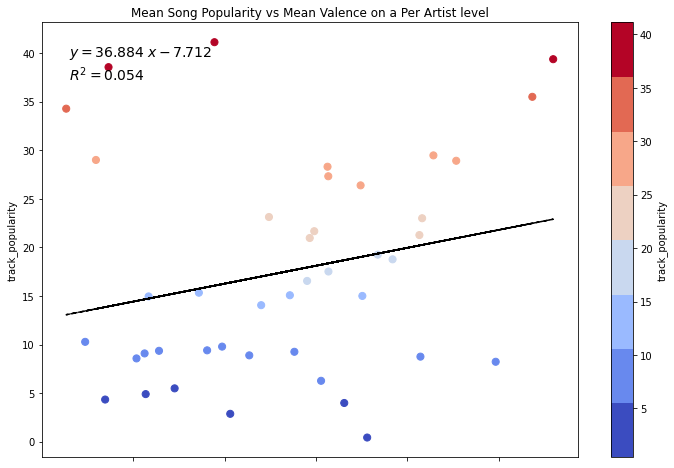

In [124]:
compare_features(mean_urbanos, 'valence', title="Mean Song Popularity vs Mean Valence on a Per Artist level")


With the valence parameter we keep confirming aspects that appear seemingly meaningless on a per song level, end up being relevant on a per artist level. Although interestingly, the two top artsts are on the bottom of the valence scale. On the other hand, since they're outliers and the correlation is *still* evident, we can conclude that the correlation is even stronger.

Now we wonder, if meaningless per song parameters increase their importance if we look at them on a per artist basis, what would happen to parameters which are already important? Let's find out by using the most relevant per song parameters: **Tempo and Loudness**

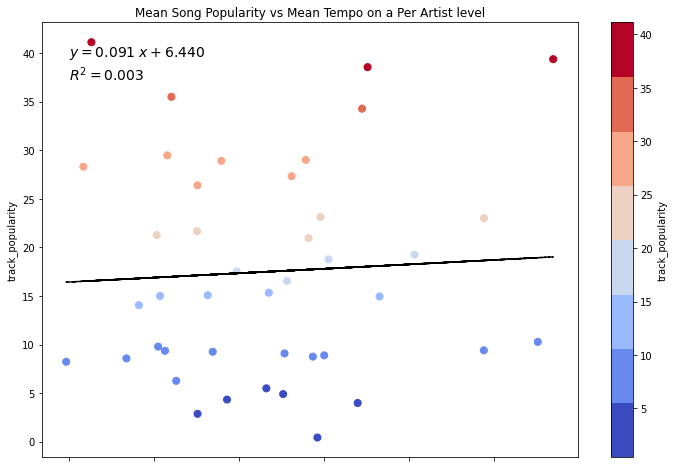

In [125]:
compare_features(mean_urbanos, 'tempo', title="Mean Song Popularity vs Mean Tempo on a Per Artist level")


Wooooooow. The importance of tempo skyrocketed. It's very, very clear now that tempo has a huge effect on popularity. Let's look at Loudness.

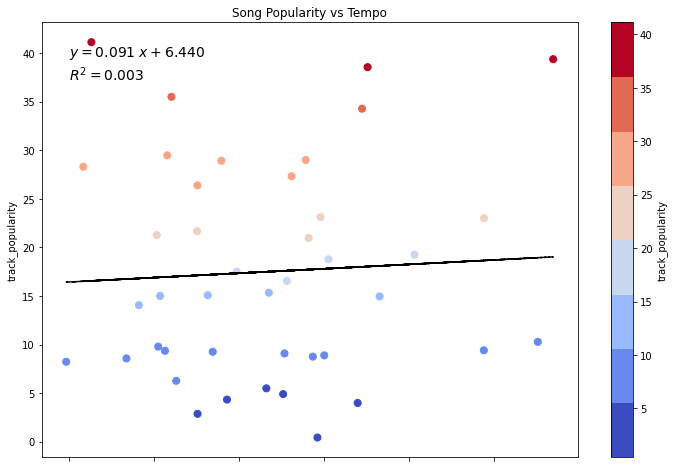

In [126]:
compare_features(mean_urbanos, 'tempo')

Mmm, seems that Tempo basically remained the same. It actually decreased 50% on a nominal level, but overall, the slope barely changed.

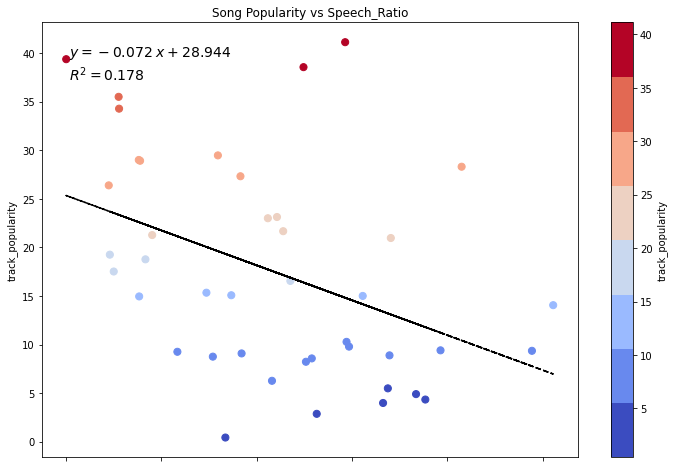

In [127]:
compare_features(mean_urbanos, 'speech_ratio')

Speech ratio nominal level decreased, but the slope is similar like the one on a per song basis.

### Conclusion ###

After reviewing more than 300 songs from dominican urban artitsts, and considering contexts such as each artist individual popularity, we can conclude that in order to have popular songs, the most important aspects to consider when producing a song are: **Tempo, Amount of Speech, Loudness and the Key used for the composition**.

Tempo: Fast-paced rhythms is the name of the game in urban music. Try to have tempos above 120 BPM.
Amount of Speech: Don't talk too much, let the music do the job. This doesn't diminish the importance of the rapper/singer, but does prove the producer is at least as equally important, if not more.
Loudness: Seems that anything above -5 dB is game.
Key: High-key music tends to produce better results, so anything above 5/Fa and mostly on a major key, will yield good results.

So the parameters to have an urban dominican hit song will be **120 BPM, on 5/Fa Major, sound above -4dB and don't have a lot of lyrics**